In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [1]:
crops = ['Corn', 'Soybean', "Wheat", "Rice"]
phases = [1,2]

In [23]:
# Read in the region_yield_reduction
region_yield_reduction = pd.read_excel(".." + os.sep + "reports" + os.sep + "Prediction_statistics.xlsx", sheet_name = "Continent_statistics")
# Drop the first row empty row
region_yield_reduction = region_yield_reduction.drop(0)
# Rename the columns
region_yield_reduction.columns = ["Crop", "Continent", "Yield_SPAM2010", "Yield_fitted_values", "Yield_phase1", "Yield_phase2", "RelativeChange_phase1", "Relative_Change_phase2"]
region_yield_reduction = region_yield_reduction[['Crop', 'Continent', 'RelativeChange_phase1', 'Relative_Change_phase2']]
# Reshape the region_yield_reduction so that it is in long format
region_yield_reduction = pd.melt(region_yield_reduction, id_vars = ['Crop', 'Continent'], value_vars = ['RelativeChange_phase1', 'Relative_Change_phase2'], var_name = 'Phase', value_name = 'Relative_Change')
# Replace RelativeChange_phase1 with 1 and Relative_Change_phase2 with 2
region_yield_reduction['Phase'] = region_yield_reduction['Phase'].replace({'RelativeChange_phase1': 1, 'Relative_Change_phase2': 2})
# Forwardfill the crop column
region_yield_reduction['Crop'] = region_yield_reduction['Crop'].fillna(method = 'ffill')
# Rename relative change to "Yield Reduction (%)"
region_yield_reduction = region_yield_reduction.rename(columns = {'Relative_Change': 'Yield Reduction (%)'})
# Convert the Yield Reduction (%) column to numeric and multiply by 100 to mae it a percentage
region_yield_reduction['Yield Reduction (%)'] = pd.to_numeric(region_yield_reduction['Yield Reduction (%)']) * 100
region_yield_reduction

,Crop,Continent,Phase,Yield Reduction (%)
0,Corn,Africa,1,-24.0
1,Corn,Asia,1,-29.0
2,Corn,Europe,1,-18.0
3,Corn,North America,1,-34.0
4,Corn,Oceania,1,-22.0
5,Corn,South America,1,-29.0
6,Rice,Africa,1,-25.0
7,Rice,Asia,1,-32.0
8,Rice,Europe,1,-29.0
9,Rice,North America,1,-34.0


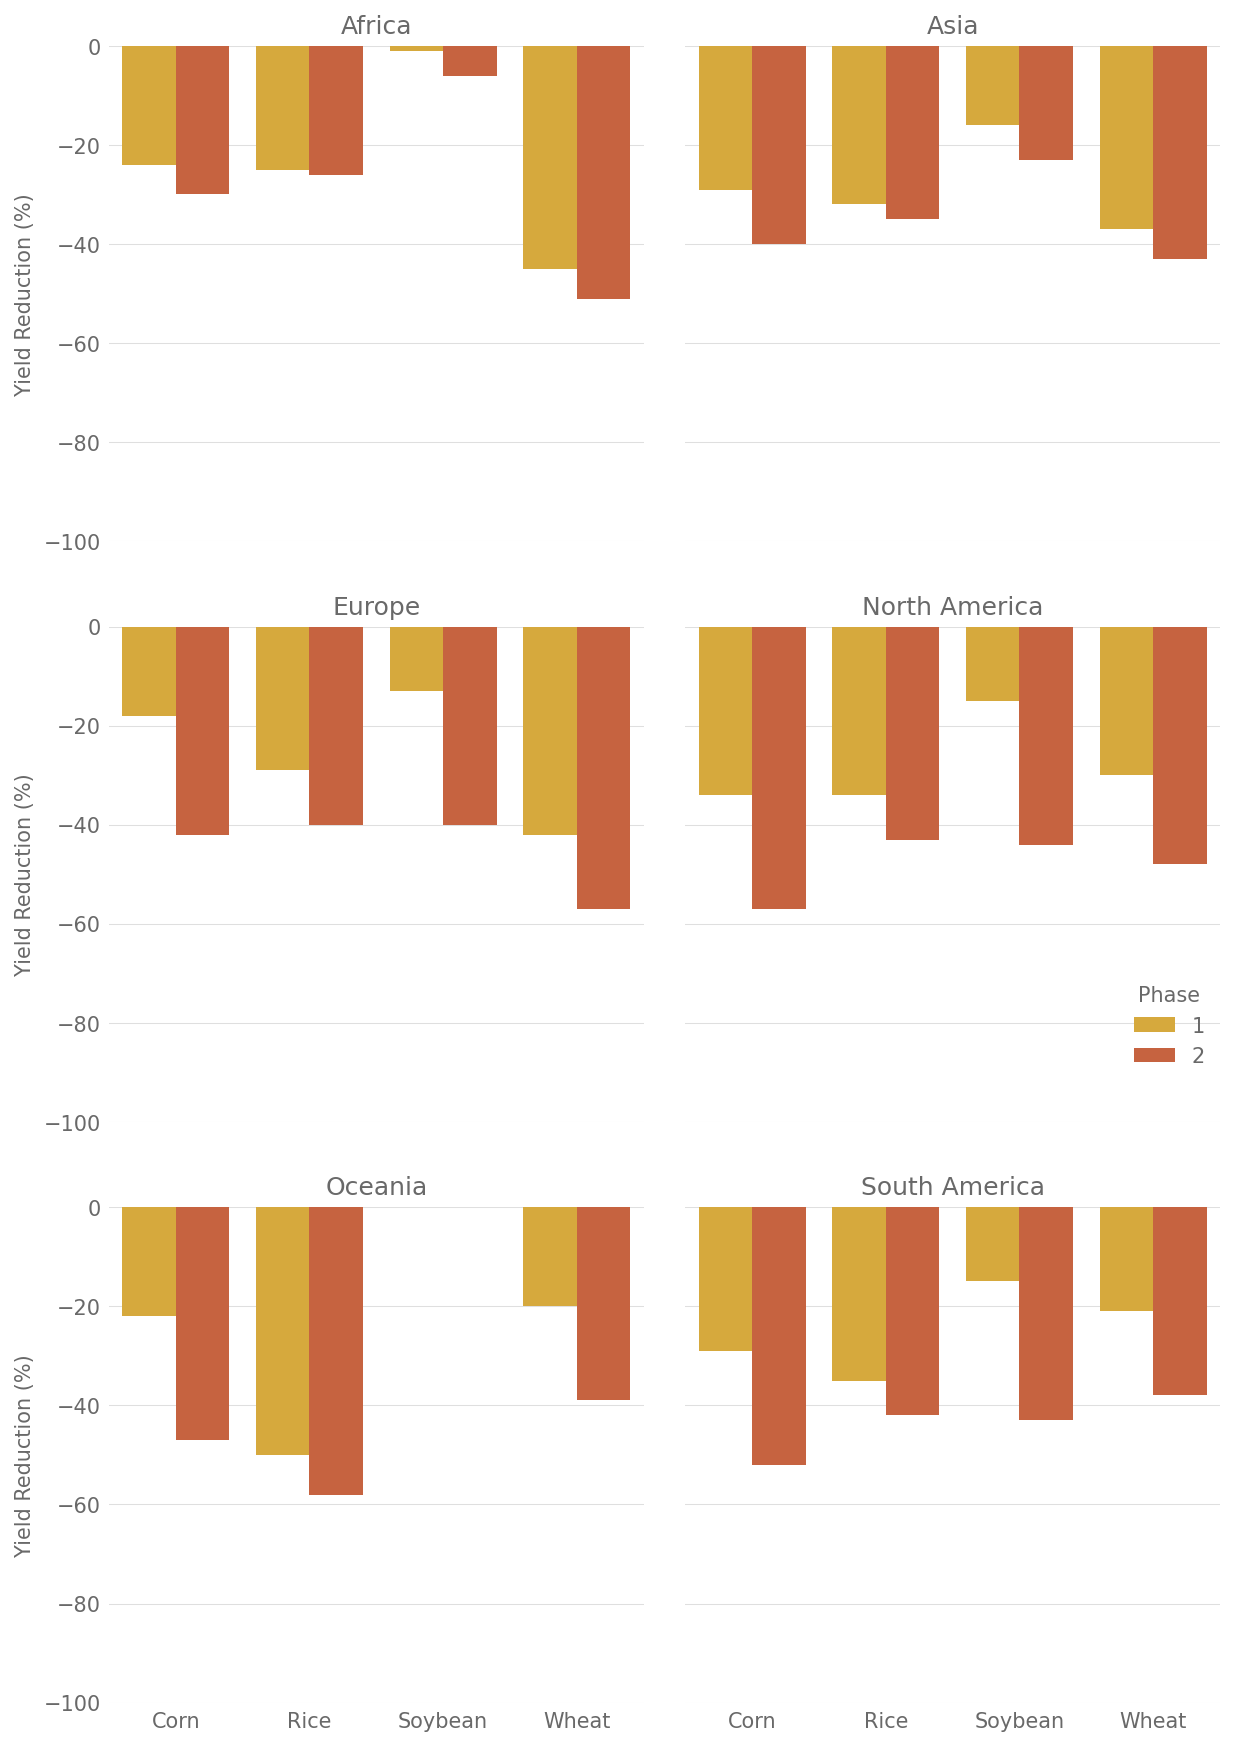

In [30]:


plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")
# Set up the figure and subplots
g = sns.catplot(
        data=region_yield_reduction,
        x='Crop',
        y='Yield Reduction (%)',
        col="Continent",
        hue='Phase',
        kind='bar',
        height=4,
        aspect=1,
        col_wrap=2,
        palette= ['#F0B323', '#DC582A']
    )
# Adjust the legend position
g._legend.set_bbox_to_anchor([0.95, 0.4])

# Set the titles for each subplot
for ax in g.axes.flat:
    region = ax.get_title().split(' = ')[1]
    ax.set_title(region)
    ax.set_ylim(-100, 0)
    ax.set_ylabel("Yield Reduction (%)")
    ax.set_xlabel("")
    # Hide borders
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
   

# Adjust the spacing between subplots
g.fig.tight_layout(pad=2)

# Show the plot
plt.savefig("../" + os.sep + "reports" + os.sep + "figures" + os.sep + "yield_reduction_by_region.png", dpi=300, bbox_inches='tight')